In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 333 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 35.4 MB/s 
     |████████████████████████████████| 182 kB 74.0 MB/s 
     |████████████████████████████████| 168 kB 70.7 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 140 kB 62.1 MB/s 


In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 1,
    "encoder_hidden_size" : 64,
    "decoder_output_size" : 1,
    "projection_size" : 64,
    "num_layers" : 3,
    "dropout" : 0.2
}

In [6]:
# load all that we need
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Log Adj Close', 'Log Return', 10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * 100
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        return data
    
    def prepare_data(self, data):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization
        """
        vol_10 = data['10-day-vol'].values
        dataset = vol_10.reshape(-1, 1)[11:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
dataset, scaler = volatiltiy_data.prepare_data(data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
(8290, 1)


In [7]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, -1))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.dataset[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps].view(self.batch_size, time_steps, self.feature_size)
            label = y[:, index+time_steps].view(self.batch_size, self.feature_size)
            index += 1
            yield input, label

In [8]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, batch_size=config["batch_size"], sequence_length=config["look_back"])
tmp = iter(dataloader)
input, label = next(tmp)
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 1])
label shape = torch.Size([32, 1])


In [15]:
# Listener
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, feature_dim, encoder_hidden_size):
        super(Listener, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=encoder_hidden_size, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True)
        
    def forward(self, x):
        x, h = self.lstm(x)
        return x

In [22]:
# sanity check
encoder = Listener(feature_dim=config['feature_dim'], encoder_hidden_size=config['encoder_hidden_size']).to(device)
print(encoder)
encoder_output = encoder(input.to(device))
print(encoder_output.size())

Listener(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.2)
)
torch.Size([32, 60, 64])


In [28]:
class Attention(torch.nn.Module):
    '''
    Attention is calculated using the key, value (from encoder hidden states) and query from decoder.
    Here are different ways to compute attention and context:

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    masked_raw_weights  = mask(raw_weights) # mask out padded elements with big negative number (e.g. -1e9 or -inf in FP16)
    attention           = softmax(masked_raw_weights)
    context             = bmm(attention, value)

    At the end, you can pass context through a linear layer too.
    '''
    
    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        # Note Dq = Dv = projection_size
        super(Attention, self).__init__()
        self.projection_size  = projection_size
        self.key_projection   = torch.nn.Linear(in_features=encoder_hidden_size, out_features=projection_size)
        self.value_projection = torch.nn.Linear(in_features=encoder_hidden_size, out_features=projection_size)
        self.query_projection = torch.nn.Linear(in_features=projection_size, out_features=projection_size)

    # As you know, in the attention mechanism, the key, value and mask are calculated only once.
    # This function is used to calculate them and set them to self
    def set_key_value_mask(self, encoder_outputs):
        '''
        Since each sentence is of differen length, we need to mask out the section of encoder_outputs that are padded with nonsense 

        Input:
           encoder_outputs -> (batch_size, timesteps, encoder_hidden_size)

        Output:
            self.padding_mask -> (batch_size, timesteps) : The mask is False for all indicies before padding begins, True for all indices after.
        '''
        self.key      = self.key_projection(encoder_outputs)
        self.value    = self.value_projection(encoder_outputs)
        
    def forward(self, decoder_output_embedding):
        '''
        Find the best output based on attention weights.
        Condense information at each timestep based on attention weight computed from query, key and value.

        Input:
            decoder_output_embedding -> (batch_size, projection_size)
        
        Output:
            context -> (batch_size, projection_size)
            attention -> (batch_size, timesteps)

        Dimension:
            key   -> (batch_size, timesteps, projection_size) : Each row vector K_j represents the relevance of E_j to any output.
            value -> (batch_size, timesteps, projection_size) : Each row vector V_j represents the actual feature E_j contributes to any output.
            query -> (batch_size, projection_size)
            raw_weights -> (batch_size, timesteps) : Each jth component is the attention weight for E_j. We only need this one attention weight to all projection_size.
            attention_weights -> (batch_size, timesteps) : Each row represent the attention to pay to each timestep.
        '''
        # Project the query using query_projection
        self.query         = self.query_projection(decoder_output_embedding)
        # Calculate raw_weights which is the product of query and key, and is of shape (batch_size, timesteps)
        raw_weights        = torch.bmm(self.key, self.query.unsqueeze(2)).squeeze(2) / np.sqrt(self.projection_size)
        # TODO: Calculate the attention weights, which is the softmax of raw_weights
        attention_weights  = torch.nn.functional.softmax(raw_weights, dim=1) # (batch, timesteps)
        # TODO: Calculate the context - it is a product between attention_weights and value
        context            = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1) # (batch_size, projection_size)

        return context, attention_weights

In [29]:
attention = Attention(config['encoder_hidden_size'], config['decoder_output_size'], config['projection_size']).to(device)
attention.set_key_value_mask(encoder_output)
np.shape(attention.key)

torch.Size([32, 60, 64])

In [30]:
# Speller
class Speller(torch.nn.Module):

    def __init__(self, encoder_hidden_size, decoder_hidden_size, decoder_output_size, vocab_size, projection_size, attention_module= None):
        super().__init__()

        self.embedding          = torch.nn.Embedding(encoder_hidden_size, projection_size, padding_idx=0)

        self.lstm_cells         = torch.nn.Sequential(
                                    torch.nn.LSTMCell(input_size=projection_size+1, hidden_size=decoder_hidden_size),
                                    torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=projection_size)
                                )
    
                                # We are using LSTMCells because process individual time steps inputs and not the whole sequence.
                                # Think why we need this in terms of the query

        # TODO: Initialize the classification layer to generate your probability distribution over all characters
        self.char_prob1         = torch.nn.Linear(projection_size*2, projection_size)

        self.ReLU               = torch.nn.ReLU(inplace=True)

        self.char_prob2         = torch.nn.Linear(projection_size, 1)

        self.attention          = attention_module

        self.projection_size    = projection_size

        self.dropout            = torch.nn.Dropout(p=0.2)
    

    def forward(self, encoder_outputs, y = None, tf_rate = 1, training=False): 

        '''
        Given encoder_outputs and encoder_lens, perform decoding to find the most likely sequence of output

        Input: 
            encoder_outputs -> (batch_size, encoder_max_seq_len, encoder_dim)
            y -> (batch_size, sequence_length, vocab_size) : sequence of your transcript during training

        Output:

        Dimension:
            label_embeded -> (batch_size, sequence_length, embed_size)
            char -> (batch_size, )
            char_embed -> (batch_size, embed_size)
            context -> (batch_size, projection_size)
            hidden_states -> (#lstm_cell, (h_1, c_1))
            decoder_output_embedding -> (batch_size, projection_size)
            attention_weights -> (batch_size, timestep)
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape

        # INITS
        predictions   = []

        # Initialize the first character input to your decoder, SOS
        char   = torch.zeros(batch_size, 1)

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*len(self.lstm_cells)

        # Set Attention Key, Value, Padding Mask just once
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs)

        # Initialize context (You have a few choices, refer to the writeup )
        context, _ = self.attention(torch.zeros(batch_size, self.projection_size).to(device))

        # TODO: What do we want to concatenate as input to the decoder? (Use torch.cat)
        decoder_input_embedding = torch.cat([char, context], dim=1) # (batch_size, timesteps + 1)
        
        # Loop over your lstm cells
        # Each lstm cell takes in an embedding
        for i in range(len(self.lstm_cells)):
            # Using 2 LSTM Cells is akin to a 2 layer LSTM looped through t timesteps 
            # An LSTM Cell returns (h,c) -> h = hidden state, c = cell memory state
            # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
            decoder_input_embedding = self.dropout(decoder_input_embedding) # Goes in with (batch_size, 1, timesteps + projection_size) since there is just one timestep, same as normal dropout

            hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i])

            decoder_input_embedding = hidden_states[i][0]

        # The output embedding from the decoder is the hidden state of the last LSTM Cell
        decoder_output_embedding = hidden_states[-1][0]

        # We compute attention from the output of the last LSTM Cell
        if self.attention != None:
            # attention_weights -> (batch_size, timestep)
            context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query

        # TODO: Concatenate the projected query with context for the output embedding
        output_embedding     = torch.cat([decoder_output_embedding, context], dim=1) # (batch_size, projection_size*2)
        # Hint: How can you get the projected query from attention
        # If you are not using attention, what will you use instead of query?

        char_prob1     = self.char_prob1(output_embedding) # (batch_size, projection_size)
        
        char_prob1     = self.ReLU(char_prob1)

        prediction     = self.char_prob2(char_prob1) # (batch_size, 1)
        
        return prediction

In [ ]:
Speller

In [ ]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)
        self.attention = 

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [ ]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                 
0_lstm              -  [32, 60, 64]  83.712k   82.176k
1_relu              -      [32, 64]        -         -
2_linear      [64, 1]       [32, 1]     65.0      64.0
-------------------------------------------------------
                       Totals
Total params          83.777k
Trainable params      83.777k
Non-trainable params      0.0
Mult-Adds              82.24k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 60, 64]",83712.0,82176.0
1_relu,-,"[32, 64]",NaN,NaN
2_linear,"[64, 1]","[32, 1]",65.0,64.0


In [ ]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [ ]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [ ]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [ ]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_base", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: quantoalpha. Use `wandb login --relogin` to force relogin


In [ ]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_bidrectional'
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler': scheduler_lr.state_dict(),
                    'val_loss': val_loss, 
                    'epoch': epoch}, path)
wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.0042845	 Eval Loss 0.0117352	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0025230	 Eval Loss 0.0074847	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0022419	 Eval Loss 0.0075151	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0022517	 Eval Loss 0.0079697	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0022540	 Eval Loss 0.0076846	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0022278	 Eval Loss 0.0078949	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0022153	 Eval Loss 0.0079429	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0022075	 Eval Loss 0.0077852	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0022146	 Eval Loss 0.0082604	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0022562	 Eval Loss 0.0084982	 Learning Rate 0.0010	


Epoch 00011: reducing learning rate of group 0 to 7.5000e-04.

Epoch 11/100: 
	 Train Loss 0.0022709	 Eval Loss 0.0084145	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0022661	 Eval Loss 0.0079405	 Learning Rate 0.0008	



Epoch 13/100: 
	 Train Loss 0.0022487	 Eval Loss 0.0075222	 Learning Rate 0.0008	


Epoch 00014: reducing learning rate of group 0 to 5.6250e-04.

Epoch 14/100: 
	 Train Loss 0.0022656	 Eval Loss 0.0078187	 Learning Rate 0.0008	



Epoch 15/100: 
	 Train Loss 0.0022512	 Eval Loss 0.0074950	 Learning Rate 0.0006	



Epoch 16/100: 
	 Train Loss 0.0022481	 Eval Loss 0.0075371	 Learning Rate 0.0006	


Epoch 00017: reducing learning rate of group 0 to 4.2188e-04.

Epoch 17/100: 
	 Train Loss 0.0022408	 Eval Loss 0.0074885	 Learning Rate 0.0006	



Epoch 18/100: 
	 Train Loss 0.0022286	 Eval Loss 0.0075666	 Learning Rate 0.0004	



Epoch 19/100: 
	 Train Loss 0.0022566	 Eval Loss 0.0076125	 Learning Rate 0.0004	


Epoch 00020: reducing learning rate of group 0 to 3.1641e-04.

Epoch 20/100: 
	 Train Loss 0.0022493	 Eval Loss 0.0075272	 Learning Rate 0.0004	



Epoch 21/100: 
	 Train Loss 0.0022357	 Eval Loss 0.0075200	 Learning Rate 0.0003	



Epoch 22/100: 
	 Train Loss 0.0022310	 Eval Loss 0.0075323	 Learning Rate 0.0003	


Epoch 00023: reducing learning rate of group 0 to 2.3730e-04.

Epoch 23/100: 
	 Train Loss 0.0022258	 Eval Loss 0.0075188	 Learning Rate 0.0003	



Epoch 24/100: 
	 Train Loss 0.0022173	 Eval Loss 0.0075455	 Learning Rate 0.0002	



Epoch 25/100: 
	 Train Loss 0.0022097	 Eval Loss 0.0074156	 Learning Rate 0.0002	



Epoch 26/100: 
	 Train Loss 0.0022019	 Eval Loss 0.0074061	 Learning Rate 0.0002	



Epoch 27/100: 
	 Train Loss 0.0021920	 Eval Loss 0.0074835	 Learning Rate 0.0002	



Epoch 28/100: 
	 Train Loss 0.0021966	 Eval Loss 0.0075577	 Learning Rate 0.0002	



Epoch 29/100: 
	 Train Loss 0.0021921	 Eval Loss 0.0075037	 Learning Rate 0.0002	



Epoch 30/100: 
	 Train Loss 0.0021827	 Eval Loss 0.0075114	 Learning Rate 0.0002	



Epoch 31/100: 
	 Train Loss 0.0021761	 Eval Loss 0.0074519	 Learning Rate 0.0002	



Epoch 32/100: 
	 Train Loss 0.0021755	 Eval Loss 0.0075124	 Learning Rate 0.0002	



Epoch 33/100: 
	 Train Loss 0.0021801	 Eval Loss 0.0075055	 Learning Rate 0.0002	



Epoch 34/100: 
	 Train Loss 0.0021782	 Eval Loss 0.0075920	 Learning Rate 0.0002	


Epoch 00035: reducing learning rate of group 0 to 1.7798e-04.

Epoch 35/100: 
	 Train Loss 0.0021783	 Eval Loss 0.0075174	 Learning Rate 0.0002	



Epoch 36/100: 
	 Train Loss 0.0021611	 Eval Loss 0.0073747	 Learning Rate 0.0002	



Epoch 37/100: 
	 Train Loss 0.0021698	 Eval Loss 0.0073474	 Learning Rate 0.0002	



Epoch 38/100: 
	 Train Loss 0.0021611	 Eval Loss 0.0073632	 Learning Rate 0.0002	


Epoch 00039: reducing learning rate of group 0 to 1.3348e-04.

Epoch 39/100: 
	 Train Loss 0.0021741	 Eval Loss 0.0074127	 Learning Rate 0.0002	



Epoch 40/100: 
	 Train Loss 0.0021440	 Eval Loss 0.0073375	 Learning Rate 0.0001	



Epoch 41/100: 
	 Train Loss 0.0021246	 Eval Loss 0.0072945	 Learning Rate 0.0001	



Epoch 42/100: 
	 Train Loss 0.0021401	 Eval Loss 0.0072868	 Learning Rate 0.0001	



Epoch 43/100: 
	 Train Loss 0.0021353	 Eval Loss 0.0072568	 Learning Rate 0.0001	


Epoch 00044: reducing learning rate of group 0 to 1.0011e-04.

Epoch 44/100: 
	 Train Loss 0.0021313	 Eval Loss 0.0072590	 Learning Rate 0.0001	



Epoch 45/100: 
	 Train Loss 0.0021199	 Eval Loss 0.0072648	 Learning Rate 0.0001	



Epoch 46/100: 
	 Train Loss 0.0021191	 Eval Loss 0.0072082	 Learning Rate 0.0001	



Epoch 47/100: 
	 Train Loss 0.0021150	 Eval Loss 0.0071993	 Learning Rate 0.0001	



Epoch 48/100: 
	 Train Loss 0.0021101	 Eval Loss 0.0071609	 Learning Rate 0.0001	



Epoch 49/100: 
	 Train Loss 0.0021174	 Eval Loss 0.0071791	 Learning Rate 0.0001	



Epoch 50/100: 
	 Train Loss 0.0021017	 Eval Loss 0.0071924	 Learning Rate 0.0001	



Epoch 51/100: 
	 Train Loss 0.0021101	 Eval Loss 0.0071921	 Learning Rate 0.0001	



Epoch 52/100: 
	 Train Loss 0.0020996	 Eval Loss 0.0071672	 Learning Rate 0.0001	



Epoch 53/100: 
	 Train Loss 0.0020999	 Eval Loss 0.0071780	 Learning Rate 0.0001	



Epoch 54/100: 
	 Train Loss 0.0021085	 Eval Loss 0.0071881	 Learning Rate 0.0001	


Epoch 00055: reducing learning rate of group 0 to 7.5085e-05.

Epoch 55/100: 
	 Train Loss 0.0021062	 Eval Loss 0.0071561	 Learning Rate 0.0001	



Epoch 56/100: 
	 Train Loss 0.0020937	 Eval Loss 0.0071468	 Learning Rate 0.0001	



Epoch 57/100: 
	 Train Loss 0.0021112	 Eval Loss 0.0071075	 Learning Rate 0.0001	



Epoch 58/100: 
	 Train Loss 0.0021034	 Eval Loss 0.0070734	 Learning Rate 0.0001	


Epoch 00059: reducing learning rate of group 0 to 5.6314e-05.

Epoch 59/100: 
	 Train Loss 0.0021050	 Eval Loss 0.0070699	 Learning Rate 0.0001	



Epoch 60/100: 
	 Train Loss 0.0021108	 Eval Loss 0.0070766	 Learning Rate 0.0001	



Epoch 61/100: 
	 Train Loss 0.0021153	 Eval Loss 0.0070843	 Learning Rate 0.0001	


Epoch 00062: reducing learning rate of group 0 to 4.2235e-05.

Epoch 62/100: 
	 Train Loss 0.0021262	 Eval Loss 0.0070966	 Learning Rate 0.0001	



Epoch 63/100: 
	 Train Loss 0.0021328	 Eval Loss 0.0070636	 Learning Rate 0.0000	



Epoch 64/100: 
	 Train Loss 0.0021232	 Eval Loss 0.0070473	 Learning Rate 0.0000	


Epoch 00065: reducing learning rate of group 0 to 3.1676e-05.

Epoch 65/100: 
	 Train Loss 0.0021485	 Eval Loss 0.0070530	 Learning Rate 0.0000	



Epoch 66/100: 
	 Train Loss 0.0021580	 Eval Loss 0.0070320	 Learning Rate 0.0000	



Epoch 67/100: 
	 Train Loss 0.0021562	 Eval Loss 0.0070146	 Learning Rate 0.0000	


Epoch 00068: reducing learning rate of group 0 to 2.3757e-05.

Epoch 68/100: 
	 Train Loss 0.0021366	 Eval Loss 0.0069985	 Learning Rate 0.0000	



Epoch 69/100: 
	 Train Loss 0.0021347	 Eval Loss 0.0069775	 Learning Rate 0.0000	



Epoch 70/100: 
	 Train Loss 0.0021514	 Eval Loss 0.0069643	 Learning Rate 0.0000	


Epoch 00071: reducing learning rate of group 0 to 1.7818e-05.

Epoch 71/100: 
	 Train Loss 0.0021426	 Eval Loss 0.0069574	 Learning Rate 0.0000	



Epoch 72/100: 
	 Train Loss 0.0021217	 Eval Loss 0.0069684	 Learning Rate 0.0000	



Epoch 73/100: 
	 Train Loss 0.0021252	 Eval Loss 0.0069600	 Learning Rate 0.0000	


Epoch 00074: reducing learning rate of group 0 to 1.3363e-05.

Epoch 74/100: 
	 Train Loss 0.0021261	 Eval Loss 0.0069532	 Learning Rate 0.0000	



Epoch 75/100: 
	 Train Loss 0.0021196	 Eval Loss 0.0069480	 Learning Rate 0.0000	



Epoch 76/100: 
	 Train Loss 0.0021077	 Eval Loss 0.0069455	 Learning Rate 0.0000	


Epoch 00077: reducing learning rate of group 0 to 1.0023e-05.

Epoch 77/100: 
	 Train Loss 0.0021035	 Eval Loss 0.0069491	 Learning Rate 0.0000	



Epoch 78/100: 
	 Train Loss 0.0021156	 Eval Loss 0.0069486	 Learning Rate 0.0000	



Epoch 79/100: 
	 Train Loss 0.0021204	 Eval Loss 0.0069537	 Learning Rate 0.0000	



Epoch 80/100: 
	 Train Loss 0.0020886	 Eval Loss 0.0069540	 Learning Rate 0.0000	



Epoch 81/100: 
	 Train Loss 0.0021116	 Eval Loss 0.0069528	 Learning Rate 0.0000	



Epoch 82/100: 
	 Train Loss 0.0021054	 Eval Loss 0.0069505	 Learning Rate 0.0000	


Epoch 00083: reducing learning rate of group 0 to 7.5169e-06.

Epoch 83/100: 
	 Train Loss 0.0021086	 Eval Loss 0.0069491	 Learning Rate 0.0000	



Epoch 84/100: 
	 Train Loss 0.0020997	 Eval Loss 0.0069489	 Learning Rate 0.0000	



Epoch 85/100: 
	 Train Loss 0.0020867	 Eval Loss 0.0069468	 Learning Rate 0.0000	



Epoch 86/100: 
	 Train Loss 0.0021025	 Eval Loss 0.0069483	 Learning Rate 0.0000	



Epoch 87/100: 
	 Train Loss 0.0021018	 Eval Loss 0.0069417	 Learning Rate 0.0000	


Epoch 00088: reducing learning rate of group 0 to 5.6377e-06.

Epoch 88/100: 
	 Train Loss 0.0021098	 Eval Loss 0.0069380	 Learning Rate 0.0000	



Epoch 89/100: 
	 Train Loss 0.0021080	 Eval Loss 0.0069397	 Learning Rate 0.0000	



Epoch 90/100: 
	 Train Loss 0.0020890	 Eval Loss 0.0069406	 Learning Rate 0.0000	


Epoch 00091: reducing learning rate of group 0 to 4.2283e-06.

Epoch 91/100: 
	 Train Loss 0.0021039	 Eval Loss 0.0069375	 Learning Rate 0.0000	



Epoch 92/100: 
	 Train Loss 0.0021005	 Eval Loss 0.0069384	 Learning Rate 0.0000	



Epoch 93/100: 
	 Train Loss 0.0021024	 Eval Loss 0.0069349	 Learning Rate 0.0000	


Epoch 00094: reducing learning rate of group 0 to 3.1712e-06.

Epoch 94/100: 
	 Train Loss 0.0020931	 Eval Loss 0.0069372	 Learning Rate 0.0000	



Epoch 95/100: 
	 Train Loss 0.0021102	 Eval Loss 0.0069362	 Learning Rate 0.0000	



Epoch 96/100: 
	 Train Loss 0.0020811	 Eval Loss 0.0069349	 Learning Rate 0.0000	



Epoch 97/100: 
	 Train Loss 0.0020963	 Eval Loss 0.0069322	 Learning Rate 0.0000	



Epoch 98/100: 
	 Train Loss 0.0020956	 Eval Loss 0.0069307	 Learning Rate 0.0000	


Epoch 00099: reducing learning rate of group 0 to 2.3784e-06.

Epoch 99/100: 
	 Train Loss 0.0021113	 Eval Loss 0.0069324	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")



Epoch 100/100: 
	 Train Loss 0.0020959	 Eval Loss 0.0069314	 Learning Rate 0.0000	


learning_Rate,█████▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,0.0
train_loss,0.0021
val_loss,0.00693


In [ ]:
state_dict = torch.load(path)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [ ]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.006930707
Test loss : 0.007486396


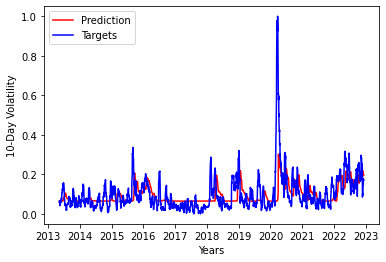

In [ ]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

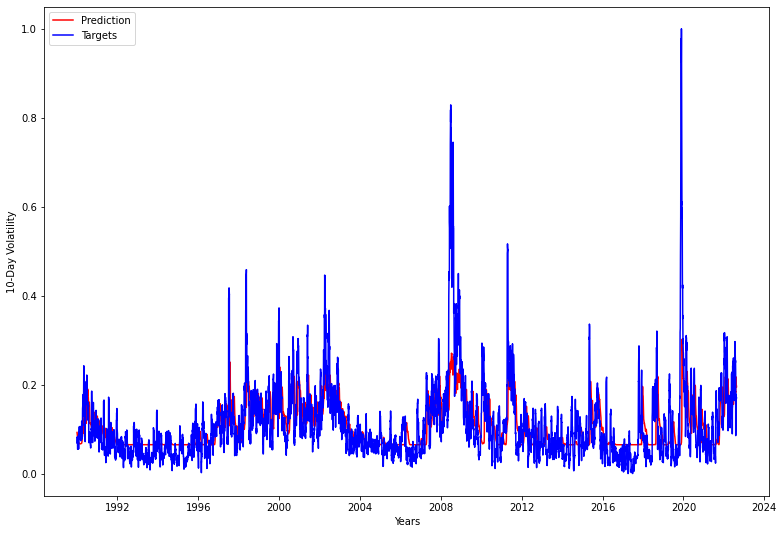

Eval loss : 0.006930707
Test loss : 0.005271878


In [ ]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)